# Patch Selection and Attention Heatmap Example

## 0. Environment setting

#### Git clone and change current working directory (free to skip)

In [15]:
!git clone https://github.com/iil-postech/semantic-attention/
import os
os.chdir('semantic-attention')

#### Install package requirements (free to skip)

In [ ]:
!pip install torch torchvision
!pip install timm==0.3.2
!pip install matplotlib

#### Import packages

In [31]:
import numpy as np
import torch
import torch.backends.cudnn as cudnn
from torchvision import transforms
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

from PIL import Image
import matplotlib.pyplot as plt

from dictionary import class_to_label

os.chdir('collaborative-inference')
import models_client
import models_server

#### Define patch selection functions

In [20]:
@torch.no_grad()
def patch_selection(attn, attention_mode, selection_mode, delta):
    def compute_rollout_attention(all_layer_matrices, start_layer=0):
        num_tokens = all_layer_matrices.shape[-1]
        all_layer_matrices += torch.eye(num_tokens, device=all_layer_matrices.device).repeat(*all_layer_matrices.shape[:-2],1,1)
        joint_attention = all_layer_matrices[start_layer]
        for i in range(start_layer+1, len(all_layer_matrices)):
            joint_attention = torch.matmul(all_layer_matrices[i], joint_attention)
        return joint_attention

    def attention_processing(attn, mode):
        if mode == 'mean':
            attn = attn[-1]
        elif mode == 'rollout':
            attn = compute_rollout_attention(attn)
        attn = attn.mean(dim=1)[:,0,1:]
        attn = attn.div(attn.sum(dim=-1, keepdim=True)).nan_to_num_()
        return attn
    
    def sel_topk(attn, th):
        return torch.topk(attn, int(th)).indices.to(attn.device)

    def sel_th(attn, th):
        len_keep = []
        index = torch.arange(attn.shape[-1], device=attn.device)
        for attn_ in attn:
            len_keep.append(index[attn_ >= th].clone())
        return len_keep

    def sel_sum_th(attn, th):
        len_keep = []
        attn_sort, index = attn.sort(dim=-1, descending=True)
        attn_sort.to(attn.device).cumsum_(dim=-1)
        index.to(attn.device)
        for attn_sort_, index_ in zip(attn_sort, index):
            len_keep.append(index_[attn_sort_ <= th].clone())
        return len_keep
    
    func_dict = {
        'topk': sel_topk,
        'attention_threshold': sel_th,
        'attention_sum_threshold': sel_sum_th
    }
    
    attn = attention_processing(attn, attention_mode)
    len_keep = func_dict[selection_mode](attn, delta)
    return len_keep, attn

#### Define visualization function

In [21]:
def show_images(images, classes, class_to_label):
    from torchvision.transforms.functional import to_pil_image

    plt.figure(figsize=(6,24))
    for i_, image in enumerate(images):
        plt.subplot(4,1,i_+1)
        plt.imshow(to_pil_image(image))
        plt.title(class_to_label[int(classes[i_])])
        plt.axis('off')
        plt.tight_layout()

    plt.show()
    plt.close()

def visual_patch_selection(images, len_keep):
    import torch.nn.functional as F

    selected = torch.zeros(images.shape[0],4,224,224)
    for i_ in range(images.shape[0]):
        ones = torch.ones(len_keep[i_].shape[-1], device=images.device)
        mask = torch.zeros(196, device=images[i_].device).scatter_(dim=0, index=len_keep[i_].type(torch.int64), src=ones)
        mask = mask.reshape(1,1,14,14)
        mask[mask == 0] = 0.2
        mask = F.interpolate(mask, scale_factor=16, mode='nearest').squeeze()
        selected[i_] = torch.cat((images[i_],mask.unsqueeze(0)),dim=0)
    
    return selected

#### Load sample images
Image titles are human-readable ground-truth labels.

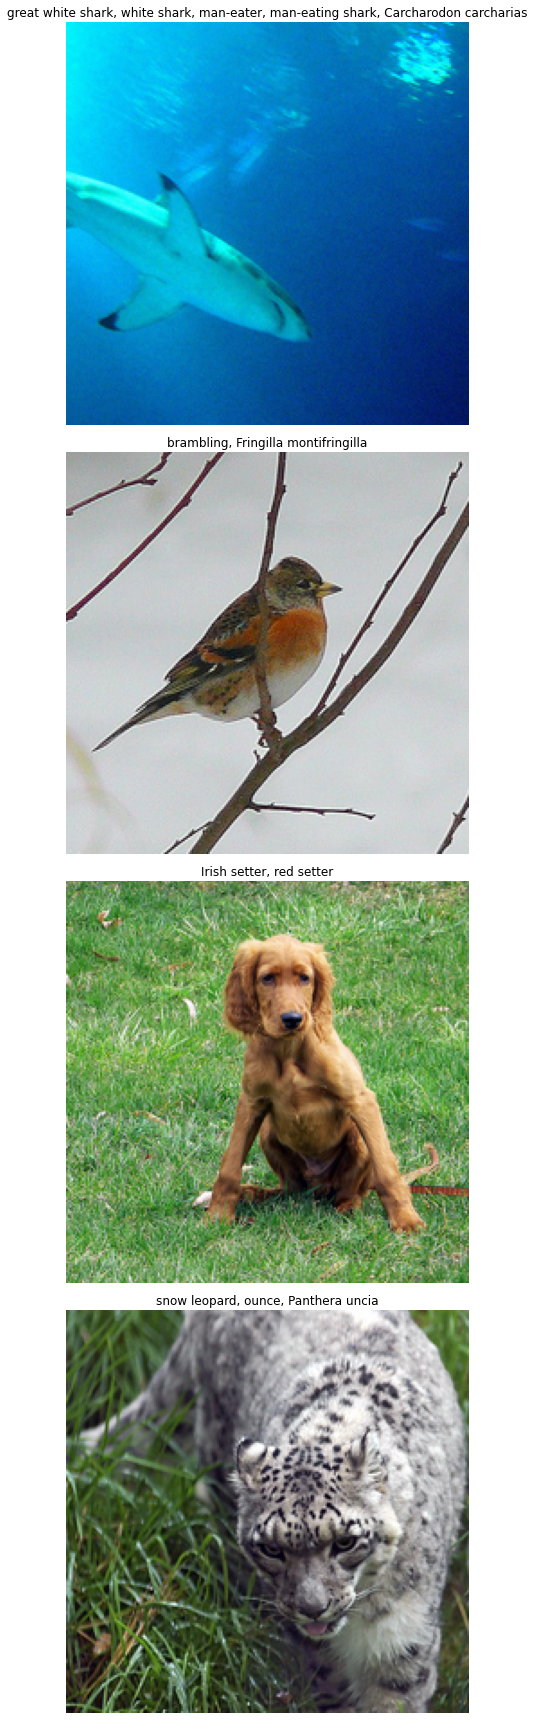

In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cudnn.benchmark = True

seed = 0
np.random.seed(seed)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)
])

reverse_transform = transforms.Compose([
    transforms.Normalize([0,0,0], [1/i for i in IMAGENET_DEFAULT_STD]),
    transforms.Normalize([-i for i in IMAGENET_DEFAULT_MEAN], [1,1,1])
])

images = None
targets = torch.empty(4, device=device)
for i_, true_label in enumerate([2, 10, 213, 289]):
    targets[i_] = true_label
    image = Image.open(r'./assets/' + str(true_label) + '.png')
    image = transform(image).to(device)
    if images is None:
        images = torch.zeros_like(image, device=device).unsqueeze(0)
        images[0] = image
    else:
        images = torch.cat((images, image.unsqueeze(0)), dim=0)
        

show_images(reverse_transform(images), targets, class_to_label)


#### Load pretrained models

In [23]:
client_model_name = 'deit_tiny_patch16_224'
server_model_name = 'deit_base_patch16_224'


model = models_client.__dict__[client_model_name](pretrained = True)
model.to(device)
model.eval()
for p in model.parameters():
    p.requires_grad = False

server_model = models_server.__dict__[server_model_name](pretrained = True)
server_model.to(device)
server_model.eval()
for p in server_model.parameters():
    p.requires_grad = False

#### Specify hyperparameters

In [24]:
# 'mean', 'rollout'
attention_score_measure = 'mean'

# 'topk', 'attention_threshold', 'attention_sum_threshold'
patch_selection_rule = 'attention_sum_threshold'
delta = 0.97

## 1. Inference on the client model

Please ensure to run the codes in the right order from 1 to 4. \
Image titles are the predicted labels on the client model.

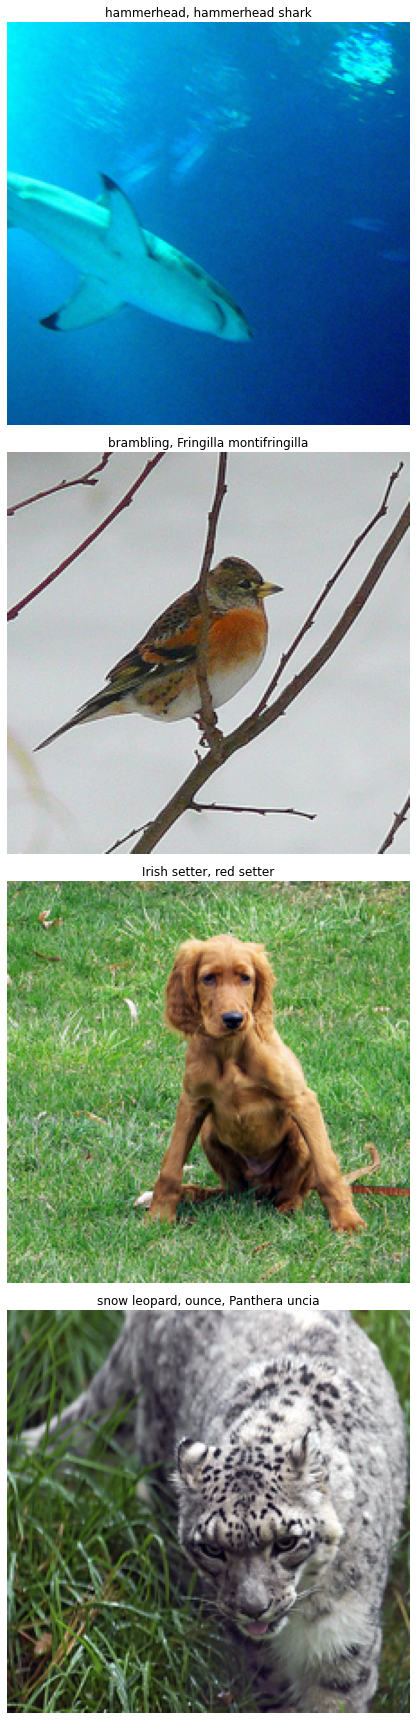

In [26]:
with torch.no_grad():
    output, attn, _ = model(images)
output = torch.argmax(output, dim=1)

show_images(reverse_transform(images), output, class_to_label)

## 2. Patch selection based on attention score

Image titles are the predicted labels on the client model. \
The transparent patches are the redundant patches decided on the client model.

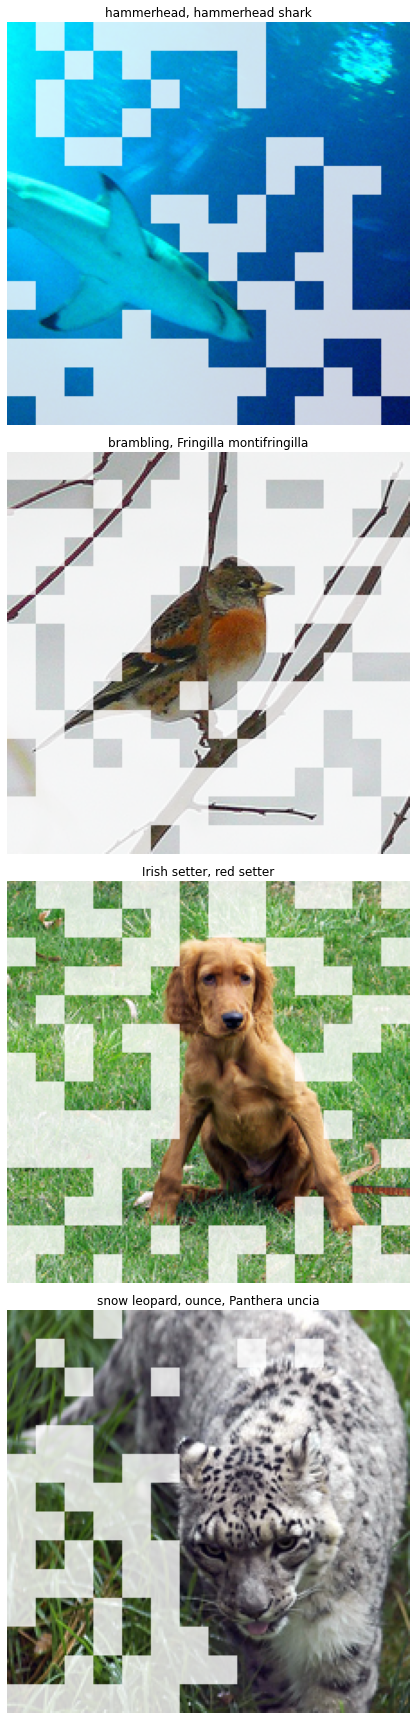

In [27]:
len_keep, attn = patch_selection(attn, attention_score_measure, patch_selection_rule, delta)
selected_images = visual_patch_selection(reverse_transform(images), len_keep)
show_images(selected_images, output, class_to_label)

## 3. Attention score heatmap

Image titles are the ground-truth labels. \
Darker patches indicate higher attention scores.

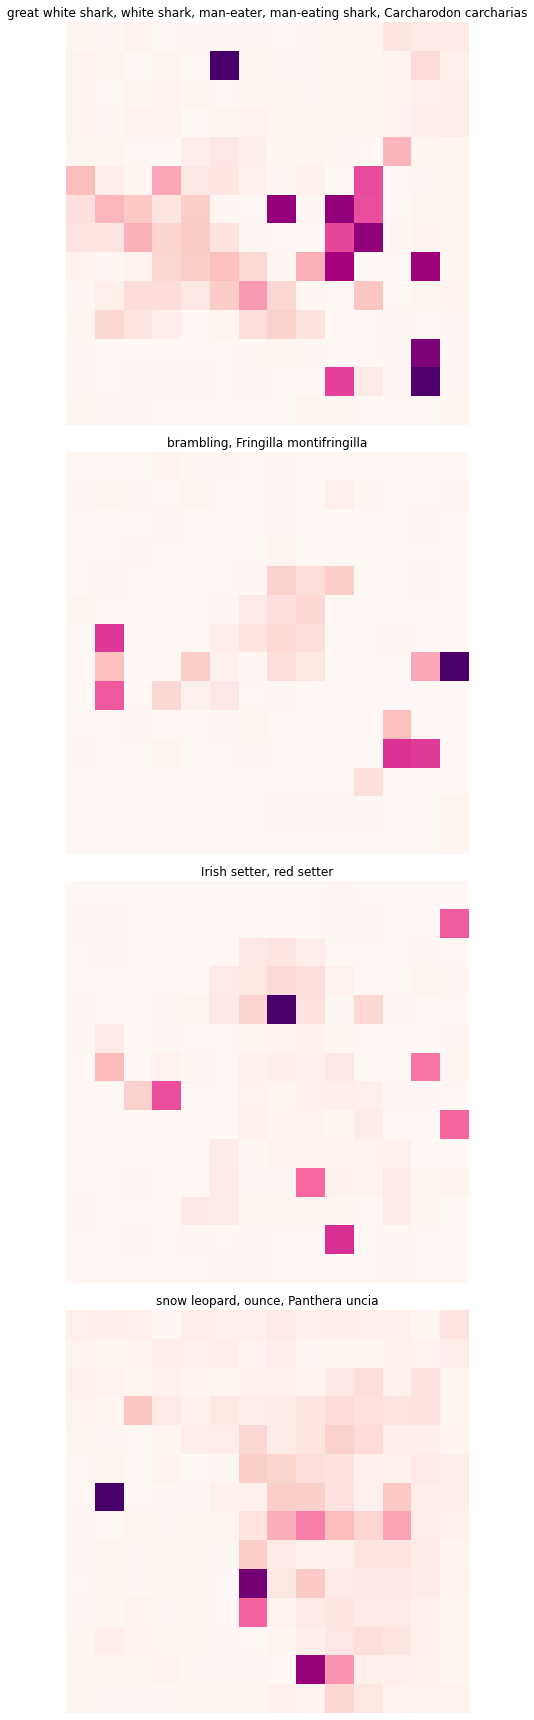

In [28]:
plt.figure(figsize=(6,24))
heatmaps = attn.reshape(attn.shape[0], 14, 14)
for i_, heatmap_ in enumerate(heatmaps):
    plt.subplot(4,1,i_+1)
    plt.imshow(heatmap_.cpu(), cmap='RdPu', interpolation='nearest')
    plt.title(class_to_label[int(targets[i_])])
    plt.axis('off')
    plt.tight_layout()

plt.show()
plt.close()

## 4. Inference on the server model

In [29]:
with torch.no_grad():
    server_output = torch.zeros(images.shape[0], 1000, device=device)
    if isinstance(len_keep, torch.Tensor):
        server_output = server_model(images, len_keep)
    else:
        for i_ in range(images.shape[0]):
            server_output[[i_]] = server_model(images[[i_]], len_keep[i_].unsqueeze(0))
server_output = torch.argmax(server_output, dim=1)

def class_lists(classes, class_to_label):
    for c_ in classes:
        print('{}; '.format(class_to_label[int(c_)]))

print('Ground-truths: [')
class_lists(targets, class_to_label)
print('] \n')
print('Client predictions: [')
class_lists(output, class_to_label)
print('] \n')
print('Server predictions: [')
class_lists(server_output, class_to_label)
print('] \n')

Ground-truths: [
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias; 
brambling, Fringilla montifringilla; 
Irish setter, red setter; 
snow leopard, ounce, Panthera uncia; 
] 

Client predictions: [
hammerhead, hammerhead shark; 
brambling, Fringilla montifringilla; 
Irish setter, red setter; 
snow leopard, ounce, Panthera uncia; 
] 

Server predictions: [
great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias; 
brambling, Fringilla montifringilla; 
Irish setter, red setter; 
snow leopard, ounce, Panthera uncia; 
] 

